# Countries Explorative Data Analysis (EDA)

In [2]:
import csv
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import requests
import seaborn as sns
import time

## Overview
The data contains information about 186 countries.
The data can help analyze the population, area, and different details about the countries

## Questions for Analysis
1. What is the population distribution?
2. What is the most and least populated country?
3. What is the most and least populated continent?
4. What is the country with the largest and smallest average area?
5. What is the continent with the largest and smallest average area?
6. What is the country with the most inequality of wealth?
7. What is the continent with the most/least equality of wealth?
8. What is the most spoken language in the world?
9. How many countries drive on the left side?
10. How many countries are still not independant?
11. What is the continent with the most countries?
12. What country got his independence last?

## About Dataset

The dataset contains information about all the 250 delegations in the world. The datasetcomes from two different APIs and websites
- REST Countries API
- Restful Countries API

### Columns description
- ```a```
- b
- c
- d
- e

## Data Collection

### Create CSV file from first API

In [8]:
# Handle ChunkedEncodingError by adding 'try except' and adding 1 second pause between each attempt
for attempt in range(5):
    country_list = []
    
    try:
        response = requests.get('https://restcountries.com/v3.1/all')
        
        if response.status_code != 200:
            print('Failed to find data')

        countriesJson = json.loads(response.content)

        # Collect relevant columns
        for item in countriesJson:
            keys = item.keys()
            country = {
                'name': item['name']['common'],
                'cca3': item['cca3'],
                'continent' : item['continents'][0],
                'area': item['area'],
                'car_side': item['car']['side'],
                'gini': list(item['gini'].values())[0] if 'gini' in keys else None,
                'languages': ', '.join(list(item['languages'].values())) if 'languages' in keys else None
            }
            country_list.append(country)

        header = country_list[0].keys()

        # Create/replace CSV file
        with open('Data/countries1.csv', 'w', newline='') as output_file:
            dict_writer = csv.DictWriter(output_file, header)
            dict_writer.writeheader()
            dict_writer.writerows(country_list)
            output_file.close()
            print('CSV file', output_file.name, 'created')
    
        break
    except requests.exceptions.ChunkedEncodingError:
        time.sleep(1)
else:
    print('Failed to fetch data from REST countries API')

Failed to fetch data from REST countries API


### Create CSV file from second API

In [10]:
# Request data
api_key = '1787|qM666AtNiFBX3PjiuCjngNuBXh9VyRdggx94r1Hr'
url = 'https://restfulcountries.com/api/v1/countries'
headers = {'Accept': 'application/json', 'Authorization': 'Bearer' + ' ' + api_key}
                                
try:
    country_list2 = []
    response = requests.get(url, headers=headers)
    
    if response.status_code != 200:
        print('Failed to find data')
    
    countries2Json = json.loads(response.content)['data']
    
    # Collect relevant columns
    for item in countries2Json:
        country = {
            'name': item['name'],
            'iso3': item['iso3'],
            'capital': item['capital'],
            'currency': item['currency'],
            'population': item['population']
        }
        country_list2.append(country)
    
    header = country_list2[0].keys()
    
    # Create/replace CSV file
    with open('Data/countries2.csv', 'w', newline='') as output_file:
        dict_writer = csv.DictWriter(output_file, header)
        dict_writer.writeheader()
        dict_writer.writerows(country_list2)
        output_file.close()
        print('CSV file', output_file.name, 'created')
        
except:
    print('Failed to fetch data from Restful Countries API')

CSV file Data/countries2.csv created


### Create dataframe from 2 CSV files

In [12]:
# Get number of rows/columns of each dataframe
countries1 = pd.read_csv('Data/countries1.csv')
print('Countries 1 shape:', countries1.shape)

countries2 = pd.read_csv('Data/countries2.csv')
print('Countries 2 shape:', countries2.shape)

Countries 1 shape: (250, 7)
Countries 2 shape: (186, 5)


In [13]:
# Merge dataframes
countries = countries1.merge(right=countries2, how='inner', left_on='cca3', right_on='iso3')
print('Merged dataframe shape:', countries.shape)

Merged dataframe shape: (186, 12)


## Data Exploration

In [15]:
countries.head()

,name_x,cca3,continent,area,car_side,gini,languages,name_y,iso3,capital,currency,population
0,Grenada,GRD,North America,344.0,left,NaN,English,Grenada,GRD,St. George's,XCD,"112,742"
1,Switzerland,CHE,Europe,41284.0,right,33.1,"French, Swiss German, Italian, Romansh",Switzerland,CHE,Berne,CHF,"8,681,478"
2,Sierra Leone,SLE,Africa,71740.0,right,35.7,English,Sierra Leone,SLE,Freetown,SLL,"8,047,131"
3,Hungary,HUN,Europe,93028.0,right,29.6,Hungarian,Hungary,HUN,Budapest,HUF,"9,650,147"
4,Taiwan,TWN,Asia,36193.0,right,NaN,Chinese,Taiwan,TWN,Taipei,TWD,"23,834,918"


In [16]:
countries.tail()

,name_x,cca3,continent,area,car_side,gini,languages,name_y,iso3,capital,currency,population
181,Republic of the Congo,COG,Africa,342000.0,right,48.9,"French, Kikongo, Lingala",Congo,COG,Brazzaville,XAF,"5,576,861"
182,Belgium,BEL,Europe,30528.0,right,27.2,"German, French, Dutch",Belgium,BEL,Brussels,EUR,"11,610,784"
183,Israel,ISR,Asia,20770.0,right,39.0,"Arabic, Hebrew",Israel,ISR,Jerusalem,ILS,"8,713,402"
184,New Zealand,NZL,Oceania,270467.0,left,NaN,"English, Māori, New Zealand Sign Language",New Zealand,NZL,Wellington,NZD,"4,838,834"
185,Nicaragua,NIC,North America,130373.0,right,46.2,Spanish,Nicaragua,NIC,Managua,NIO,"6,658,149"


In [17]:
countries.sample(5)

,name_x,cca3,continent,area,car_side,gini,languages,name_y,iso3,capital,currency,population
163,Brazil,BRA,South America,8515767.0,right,53.4,Portuguese,Brazil,BRA,Brasilia,BRL,"213,196,006"
181,Republic of the Congo,COG,Africa,342000.0,right,48.9,"French, Kikongo, Lingala",Congo,COG,Brazzaville,XAF,"5,576,861"
128,Micronesia,FSM,Oceania,702.0,right,40.1,English,Micronesia,FSM,Palikir,USD,"551,217"
78,Canada,CAN,North America,9984670.0,right,33.3,"English, French",Canada,CAN,Ottawa,CAD,"37,881,943"
107,Cameroon,CMR,Africa,475442.0,right,46.6,"English, French",Cameroon,CMR,Yaounde,XAF,"26,831,876"


In [18]:
countries.dtypes

name_x         object
cca3           object
continent      object
area          float64
car_side       object
gini          float64
languages      object
name_y         object
iso3           object
capital        object
currency       object
population     object
dtype: object

In [19]:
countries.describe()

,area,gini
count,1.860000e+02,159.000000
mean,7.033734e+05,38.397484
std,1.945260e+06,7.945741
min,2.020000e+00,24.600000
25%,2.777100e+04,32.850000
50%,1.375450e+05,37.100000
75%,5.457632e+05,42.850000
max,1.709824e+07,63.000000


In [20]:
countries.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 186 entries, 0 to 185
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   name_x      186 non-null    object 
 1   cca3        186 non-null    object 
 2   continent   186 non-null    object 
 3   area        186 non-null    float64
 4   car_side    186 non-null    object 
 5   gini        159 non-null    float64
 6   languages   186 non-null    object 
 7   name_y      186 non-null    object 
 8   iso3        186 non-null    object 
 9   capital     186 non-null    object 
 10  currency    186 non-null    object 
 11  population  186 non-null    object 
dtypes: float64(2), object(10)
memory usage: 17.6+ KB


There are only missing values in the ```gini``` column. We will not remove the rows.

## Data Preparation

In [23]:
# Drop the name column of the second dataframe
countries = countries.drop('name_y', axis=1).rename(columns={'name_x': 'name'})
countries.head()

,name,cca3,continent,area,car_side,gini,languages,iso3,capital,currency,population
0,Grenada,GRD,North America,344.0,left,NaN,English,GRD,St. George's,XCD,"112,742"
1,Switzerland,CHE,Europe,41284.0,right,33.1,"French, Swiss German, Italian, Romansh",CHE,Berne,CHF,"8,681,478"
2,Sierra Leone,SLE,Africa,71740.0,right,35.7,English,SLE,Freetown,SLL,"8,047,131"
3,Hungary,HUN,Europe,93028.0,right,29.6,Hungarian,HUN,Budapest,HUF,"9,650,147"
4,Taiwan,TWN,Asia,36193.0,right,NaN,Chinese,TWN,Taipei,TWD,"23,834,918"


In [24]:
# Drop the code column of the second dataframe
countries = countries.drop('iso3', axis=1).rename(columns={'cca3': 'code'})
countries.head()

,name,code,continent,area,car_side,gini,languages,capital,currency,population
0,Grenada,GRD,North America,344.0,left,NaN,English,St. George's,XCD,"112,742"
1,Switzerland,CHE,Europe,41284.0,right,33.1,"French, Swiss German, Italian, Romansh",Berne,CHF,"8,681,478"
2,Sierra Leone,SLE,Africa,71740.0,right,35.7,English,Freetown,SLL,"8,047,131"
3,Hungary,HUN,Europe,93028.0,right,29.6,Hungarian,Budapest,HUF,"9,650,147"
4,Taiwan,TWN,Asia,36193.0,right,NaN,Chinese,Taipei,TWD,"23,834,918"


In [25]:
# Convert population column from string to float
countries['population'] = countries['population'].str.replace(',', '').astype('float')
countries.dtypes

name           object
code           object
continent      object
area          float64
car_side       object
gini          float64
languages      object
capital        object
currency       object
population    float64
dtype: object

In [26]:
# Remove whitespaces from string columns
countries['name'] = countries['name'].str.strip()
countries['code'] = countries['code'].str.strip()
countries['continent'] = countries['continent'].str.strip()
countries['car_side'] = countries['car_side'].str.strip()
countries['capital'] = countries['capital'].str.strip()
countries['currency'] = countries['currency'].str.strip()
countries.head()

,name,code,continent,area,car_side,gini,languages,capital,currency,population
0,Grenada,GRD,North America,344.0,left,NaN,English,St. George's,XCD,112742.0
1,Switzerland,CHE,Europe,41284.0,right,33.1,"French, Swiss German, Italian, Romansh",Berne,CHF,8681478.0
2,Sierra Leone,SLE,Africa,71740.0,right,35.7,English,Freetown,SLL,8047131.0
3,Hungary,HUN,Europe,93028.0,right,29.6,Hungarian,Budapest,HUF,9650147.0
4,Taiwan,TWN,Asia,36193.0,right,NaN,Chinese,Taipei,TWD,23834918.0


In [27]:
# Sort countries in alphabetical order and reset index
countries = countries.sort_values(by='name').reset_index(drop=True)
countries.head(5)

,name,code,continent,area,car_side,gini,languages,capital,currency,population
0,Afghanistan,AFG,Asia,652230.0,right,NaN,"Dari, Pashto, Turkmen",Kabul,AFN,39306195.0
1,Albania,ALB,Europe,28748.0,right,33.2,Albanian,Tirana,lek,2876490.0
2,Algeria,DZA,Africa,2381741.0,right,27.6,Arabic,Algiers,DZD,44190030.0
3,Andorra,AND,Europe,468.0,right,NaN,Catalan,Andorra la Vella,EUR,77317.0
4,Angola,AGO,Africa,1246700.0,right,51.3,Portuguese,Luanda,AOA,33312843.0


In [28]:
countries.tail()

,name,code,continent,area,car_side,gini,languages,capital,currency,population
181,Venezuela,VEN,South America,916445.0,right,44.8,Spanish,Caracas,VEF,28402272.0
182,Vietnam,VNM,Asia,331212.0,right,35.7,Vietnamese,Hanoi,VND,97702766.0
183,Yemen,YEM,Asia,527968.0,right,36.7,Arabic,Sanaa,YER,30110883.0
184,Zambia,ZMB,Africa,752612.0,left,57.1,English,Lusaka,ZMK,18609335.0
185,Zimbabwe,ZWE,Africa,390757.0,left,50.3,"Chibarwe, English, Kalanga, Khoisan, Ndau, Nor...",Harare,ZWL,14955711.0


## Data Analysis

### Population

#### 1. What are the 10 most populated countries?

In [32]:
# Data

#remove scientific notation
pd.options.display.float_format = '{:.0f}'.format 

top_10_pop_countries = countries \
    .nlargest(n=10, columns='population')[['name', 'population']] \
    .set_index('name')

top_10_pop_countries

,population
name,
China,1441654790
India,1385753930
United States,331825014
Indonesia,274750669
Pakistan,222741498
Brazil,213196006
Nigeria,208355710
Bangladesh,165383477
Russia,145960720


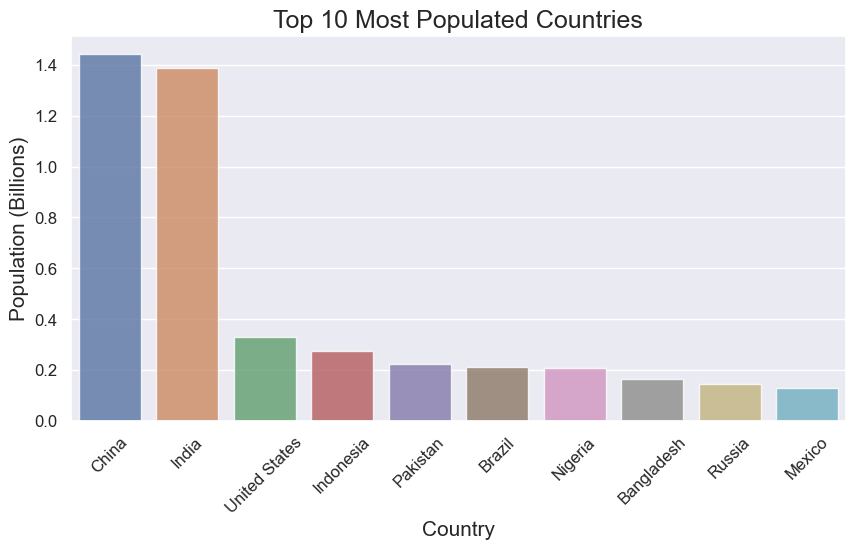

In [33]:
# Visualization

# plot
sns.set(rc={'figure.figsize': (10, 5)})
ax = sns.barplot(data=top_10_pop_countries,
                 x=top_10_pop_countries.index,
                 y=top_10_pop_countries['population'],
                 hue=top_10_pop_countries.index,
                 alpha=0.8)

# labels
ax.set_title('Top 10 Most Populated Countries', fontsize=18)
ax.set_xlabel('Country')
ax.set_ylabel('Population (Billions)')
ax.xaxis.label.set_size(15)
ax.yaxis.label.set_size(15)
ax.tick_params(axis='both', labelsize=12)
ax.tick_params(axis='x', rotation=45)

# remove scientific notation showing at the top of the y axis
ax.yaxis.offsetText.set_visible(False)

plt.show()

India has surpassed China in population in April 2023 but the data is not the most recent. That's why it show China as the first.

#### 2. What are the top 2 most populated countries by continent?

In [36]:
# Data

countries \
    .sort_values(by=['continent', 'population'], ascending=[True, False]) \
    .groupby('continent') \
    .head(2)[['continent', 'name', 'population']] \
    .reset_index(drop=True)

,continent,name,population
0,Africa,Nigeria,208355710
1,Africa,Ethiopia,116197488
2,Asia,China,1441654790
3,Asia,India,1385753930
4,Europe,Russia,145960720
5,Europe,Turkey,84726208
6,North America,United States,331825014
7,North America,Mexico,129508846
8,Oceania,Australia,25625341
9,Oceania,Papua New Guinea,17150845


#### 3. What is the most populated continent?

In [38]:
# Data

total_pop_by_continent = countries \
    .groupby('continent')[['population']] \
    .sum() \
    .sort_values(by='population', ascending=False)

total_pop_by_continent

,population
continent,
Asia,4469992174
Africa,1249575606
Europe,824367344
North America,588168584
South America,431959822
Oceania,50595527


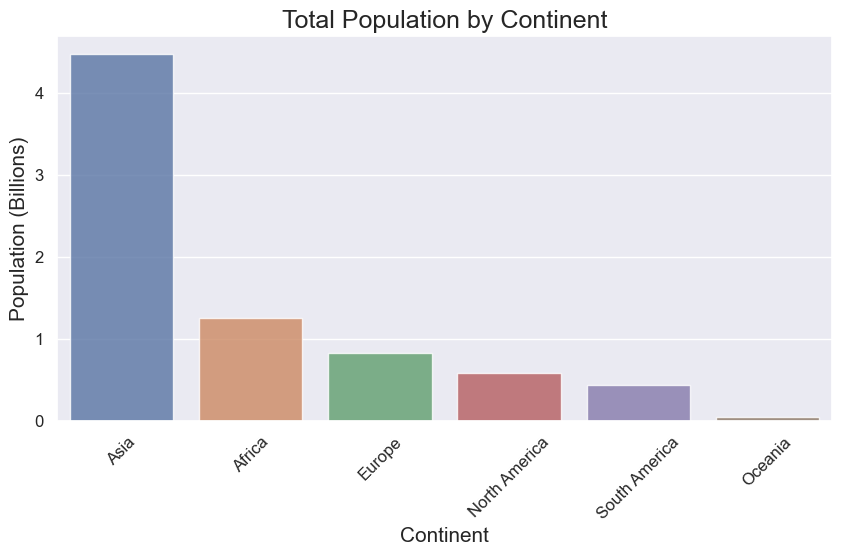

In [39]:
# Visualization

# plot
sns.set(rc={'figure.figsize': (10, 5)})
ax = sns.barplot(data=total_pop_by_continent,
                 x=total_pop_by_continent.index,
                 y=total_pop_by_continent['population'],
                 hue=total_pop_by_continent.index,
                 alpha=0.8)

# labels
ax.set_title('Total Population by Continent', fontsize=18)
ax.set_xlabel('Continent')
ax.set_ylabel('Population (Billions)')
ax.xaxis.label.set_size(15)
ax.yaxis.label.set_size(15)
ax.tick_params(axis='both', labelsize=12)
ax.tick_params(axis='x', rotation=45)

# remove scientific notation showing at the top of the y axis
ax.yaxis.offsetText.set_visible(False)

plt.show()

The most populated continent is Asia.

### Area

#### 4. What are the top 10 largest countries?

In [43]:
# Data

top_10_largest_countries = countries \
    .nlargest(n=10, columns='area')[['name', 'area']] \
    .set_index('name')

top_10_largest_countries

,area
name,
Russia,17098242
Canada,9984670
China,9706961
United States,9372610
Brazil,8515767
Australia,7692024
India,3287590
Argentina,2780400
Kazakhstan,2724900


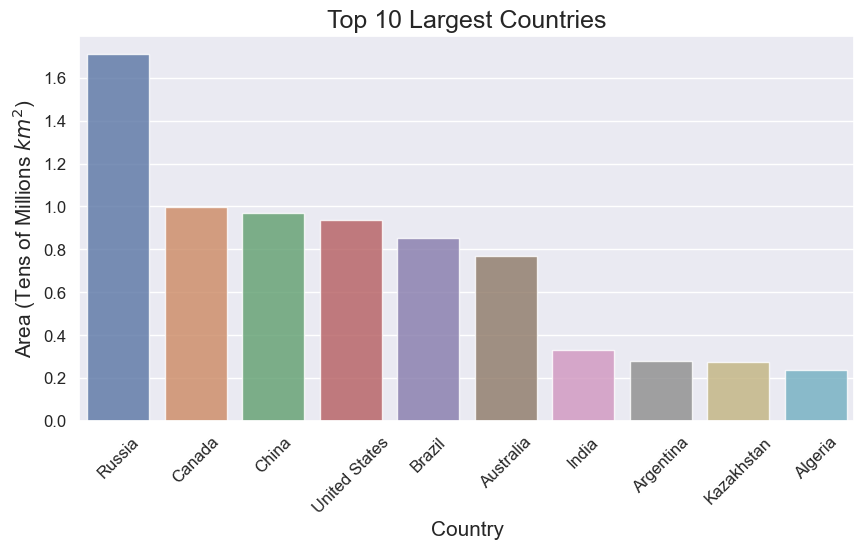

In [73]:
# Visualization

# plot
sns.set(rc={'figure.figsize': (10, 5)})
ax = sns.barplot(data=top_10_largest_countries,
                 x=top_10_largest_countries.index,
                 y=top_10_largest_countries['area'],
                 hue=top_10_largest_countries.index,
                 alpha=0.8)

# labels
ax.set_title('Top 10 Largest Countries', fontsize=18)
ax.set_xlabel('Country')
ax.set_ylabel('Area (Tens of Millions $km^2$)')
ax.xaxis.label.set_size(15)
ax.yaxis.label.set_size(15)
ax.tick_params(axis='both', labelsize=12)
ax.tick_params(axis='x', rotation=45)

# remove scientific notation showing at the top of the y axis
ax.yaxis.offsetText.set_visible(False)

plt.show()

#### 5. What are the top 2 largest countries by continent?

In [84]:
# Data

countries \
    .sort_values(by=['continent', 'area'], ascending=[True, False]) \
    .groupby('continent') \
    .head(2)[['continent', 'name', 'area']] \
    .reset_index(drop=True)

,continent,name,area
0,Africa,Algeria,2381741
1,Africa,Sudan,1886068
2,Asia,China,9706961
3,Asia,India,3287590
4,Europe,Russia,17098242
5,Europe,Turkey,783562
6,North America,Canada,9984670
7,North America,United States,9372610
8,Oceania,Australia,7692024
9,Oceania,Papua New Guinea,462840


#### 6. What is the largest continent?

In [80]:
# Data

total_area_by_continent = countries \
    .groupby('continent')[['area']] \
    .sum() \
    .sort_values(by='area', ascending=False)

total_area_by_continent

,area
continent,
Asia,31025003
Africa,27700187
Europe,23810844
North America,22063274
South America,17737675
Oceania,8490477


The largest continent is Asia.

### Driving Side

#### 7. What is the proportion of countries driving on the left vs. right side?

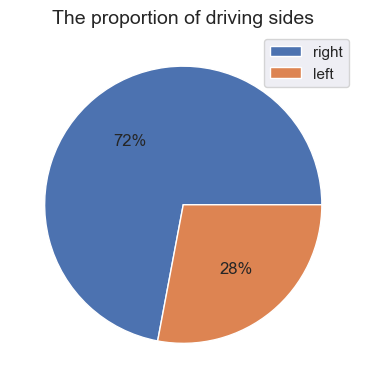

In [102]:
# Visualization

driving_sides = countries['car_side'].value_counts()
plt.pie(driving_sides, autopct='%.0f%%')
plt.title('The proportion of driving sides', fontsize=14)
plt.legend(labels=driving_sides.index)
plt.show()